# Video-based marker-free tracking and multi-scale analysis of mouse locomotor activity and behavioral aspects in an open field arena: A perspective approach to the quantification of complex gait disturbances associated with Alzheimer's disease

[![DOI:10.3389/fninf.2023.1101112](https://zenodo.org/badge/DOI/10.3389/fninf.2023.1101112.svg)](https://doi.org/10.3389/fninf.2023.1101112)
[![Citation Badge](https://api.juleskreuer.eu/citation-badge.php?doi=10.3389/fninf.2023.1101112)](https://juleskreuer.eu/projekte/citation-badge/)

Complex gait disturbances represent one of the prominent manifestations of various neurophysiological conditions, including widespread neurodegenerative disorders such as Alzheimer's and Parkinson's diseases. Therefore, instrumental measurement techniques and automatic computerized analysis appears essential for the differential diagnostics, as well as for the assessment of treatment effectiveness from experimental animal models to clinical settings. Here we present a marker-free instrumental approach to the analysis of gait disturbances in animal models. Our approach is based on the analysis of video recordings obtained with a camera placed underneath an open field arena with transparent floor using the DeeperCut algorithm capable of online tracking of individual animal body parts, such as the snout, the paws and the tail. The extracted trajectories of animal body parts are next analyzed using an original computerized methodology that relies upon a generalized scalable model based on fractional Brownian motion with parameters identified by detrended partial cross-correlation analysis. We have shown that in a mouse model representative movement patterns are characterized by two asymptotic regimes characterized by integrated 1/f noise at small scales and nearly random displacements at large scales separated by a single crossover. More detailed analysis of gait disturbances revealed that the detrended cross-correlations between the movements of the snout, paws and tail relative to the animal body midpoint exhibit statistically significant discrepancies in the Alzheimer's disease mouse model compared to the control group at scales around the location of the crossover. We expect that the proposed approach, due to its universality, robustness and clear physical interpretation, is a promising direction for the design of applied analysis tools for the diagnostics of various gait disturbances and behavioral aspects in animal models. We further believe that the suggested mathematical models could be relevant as a complementary tool in clinical diagnostics of various neurophysiological conditions associated with movement disorders.

## Dataset

The datasets presented and used in this study can be found by the following link:

https://drive.digiratory.ru/d/s/rBTj2ljCip8UiRBghESaIWz5mpvrKhAI/wMvzQfdJnIl_5RlYfPh1tZnWaBr3mcoK-KLUAgr7a_Qk.

 
## Citation

If you find this project useful, please cite:

```bib
@ARTICLE{10.3389/fninf.2023.1101112,
    AUTHOR={Bogachev, Mikhail and Sinitca, Aleksandr and Grigarevichius, Konstantin and Pyko, Nikita and Lyanova, Asya and Tsygankova, Margarita and Davletshin, Eldar and Petrov, Konstantin and Ageeva, Tatyana and Pyko, Svetlana and Kaplun, Dmitrii and Kayumov, Airat and Mukhamedshina, Yana},
    TITLE={Video-based marker-free tracking and multi-scale analysis of mouse locomotor activity and behavioral aspects in an open field arena: A perspective approach to the quantification of complex gait disturbances associated with Alzheimer's disease},
    JOURNAL={Frontiers in Neuroinformatics},
    VOLUME={17},
    YEAR={2023},
    URL={https://www.frontiersin.org/articles/10.3389/fninf.2023.1101112},       
    DOI={10.3389/fninf.2023.1101112},      
    ISSN={1662-5196},   
}

```

## Disclaimer

The results produced by this pipeline can be slightly different from the results mentioned in the paper due to variations in software versions and adoptation to the newer version.



In [1]:
import pandas as pd
import os
import math
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from StatTools.analysis.dpcca import dpcca
from StatTools.analysis.movmean import movmean

In [2]:
sns.set_theme(font_scale=1.7, style='whitegrid')

### Fluctuation functions for the movement trajectories


In [3]:
data_path = os.path.join(os.getcwd(), 'data')
target_path = os.path.join(os.getcwd(), 'export')
os.makedirs(target_path, exist_ok=True)

In [4]:
df = pd.read_csv(os.path.join(data_path, "all_mouse_trajectories.csv"), index_col=0)
MIN_LENGTH = df.shape[0]
for video in df['name'].unique():
    l = df[df['name'] == video].shape[0]
    if l < MIN_LENGTH:
        MIN_LENGTH = l
print('min:{}'.format(MIN_LENGTH))

min:11311


In [5]:
ROT_DEGREE = -5 / 4
ROT_DEGREE_STR = r"$F(s)/s^{5/4}$"

In [6]:
group_names = ['alz', 'wild']
parts_columns_names_x = ['snout_x', 'leftforword_x',
                         'rightforword_x', 'midbody_x',
                         'leftback_x', 'rightback_x',
                         'tail_x']
parts_columns_names_y = ['snout_y', 'leftforword_y',
                         'rightforword_y', 'midbody_y',
                         'leftback_y', 'rightback_y',
                         'tail_y']

In [7]:
def get_s_list(data_len):
    # Calculate scale range
    base = 1.05
    smin = 8
    smax = data_len / 4
    s_list = []

    for degree in range(int(math.log2(smin)/math.log2(base)), 
                        int(math.log2(smax)/math.log2(base))):
        new = int(base**degree)
        if new not in s_list:
            s_list.append(new)
    return s_list

After creating the csv files, one can visualize the fluctuation functions. First, DFA flucutations functions characterizing the auto-correlations in the individual movemens of each animal body part are displayed. Next, the DCCA joint fluctuation functions indicating mutual dynamics of animal body parts in terms of their cross-correlations are shown.
Here exemplified for one single Cartesian coordinate (e.g., "x"), could be duplicated for "y"

In [8]:
def get_joint_median_ff(video_df: pd.DataFrame, columns_names: List[str], min_len: int = None) -> pd.DataFrame:
    """
    Calculate joint median fluctuation functions and crossover positions for given columns.
    
    Args:
        video_df: DataFrame containing the video data
        columns_names: List of column names to analyze
        min_len: Minimum length to clip trajectories (optional)
        
    Returns:
        DataFrame containing group, name and len(columns_names)^2 crossovers
    """
    # Load and preprocess data
    data = video_df.dropna(axis=0, how='all').reset_index(drop=True)
    
    # Clip trajectories if min_len is provided
    if min_len is not None:
        data_size = len(data)
        drop_size = data_size - min_len
        if drop_size > 0:
            data = data.iloc[:-drop_size]
    
    # Prepare result DataFrame
    columns = ['file', 'group', 'name', 'f', 's', 'crossover_position']
    data_df = pd.DataFrame(columns=columns)
    
    file = video_df['name'].unique()[0]
    group = file.split('_')[-1]
    
    # Calculate scale range
    S = get_s_list(len(data))
    crossover_position = 0
    
    # Process all pairs of columns
    for i, col_i in enumerate(columns_names):
        new_row = {}
        sum_f = None
        
        # Calculate for all other columns
        for j, col_j in enumerate(columns_names):
            if col_i == col_j:
                continue
                
            _, _, f, s = dpcca(
                movmean(np.concatenate((data[col_i], data[col_j])), 5),
                pd=2, step=1, s=S, processes=2
            )
            
            sum_f = f if sum_f is None else np.vstack((sum_f, f))
        
        # Calculate median for current column with all others
        if sum_f is not None:  # Only if there were other columns to compare with
            f = np.median(sum_f, axis=0)
            new_f = movmean(np.sqrt(f), 9) * np.power(s, ROT_DEGREE)
            s_max_index = np.argmax(new_f)
            crossover_position = s[s_max_index]
            
            new_row = {
                'file': file,
                'group': group,
                'name': f"{col_i}_all",
                'f': f,
                's': s,
                'crossover_position': crossover_position
            }
            data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Calculate for each column with itself
    for col_j in columns_names:
        _, _, f, s = dpcca(
            movmean(data[col_j], 5),
            pd=2, step=1, s=S, processes=2
        )
        new_f = movmean(np.sqrt(f), 9) * np.power(s, ROT_DEGREE)
        s_max_index = np.argmax(new_f)
        crossover_position = s[s_max_index]

        crossover_position = np.argmax(
            np.sqrt(f) * np.power(s, ROT_DEGREE)
        )
        
        new_row = {
            'file': file,
            'group': group,
            'name': f"{col_j}_{col_j}",
            'f': f,
            's': s,
            'crossover_position': crossover_position
        }
        data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
    
    return data_df

In [9]:
columns = ["file", "group", "name", "f", "s", "crossover_position"]
all_data_df = pd.DataFrame([], columns=columns)
for video in tqdm(df["name"].unique()):
    mouse_df = get_joint_median_ff(df[df["name"] == video], parts_columns_names_x)
    all_data_df = pd.concat([all_data_df, mouse_df], axis=0, ignore_index=True)
all_data_df.to_csv(os.path.join(target_path, "DCCA_data_x.csv"))

# all_data_df = pd.DataFrame([], columns=columns)
# for video in tqdm(df["name"].unique()[0:1]):
#     mouse_df = get_joint_median_ff(df[df["name"] == video], parts_columns_names_y)
#     all_data_df = pd.concat([all_data_df, mouse_df], axis=0, ignore_index=True)
# all_data_df.to_csv(os.path.join(target_path, "DCCA_data_y.csv"))

100%|██████████| 23/23 [43:44<00:00, 114.12s/it]


##### Results
After create csv files, we can visualisate fluctuation functions. First, graphs are plotted for each part of the mouse body. Then you can see integral graphs (DFA and DCCA).


Here is example for "x" coordinate, you need repeat it for "y".

In [10]:
data_file = os.path.join(target_path, "DCCA_data_x.csv")  # change data path here for y
data = pd.read_csv(data_file, index_col=0)
data["crossover_position"] = pd.to_numeric(
    data["crossover_position"], downcast="integer"
)
body_parts = data.name.unique()

In [11]:
body_parts_dict = {'snout_x_all':'A-all', 'leftforword_x_all': 'B-all', 'rightforword_x_all':'C-all', 'midbody_x_all':'D-all', 
            'leftback_x_all':'E-all', 'rightback_x_all':'F-all', 'tail_x_all':'G-all',
            'snout_x_snout_x':'A-A', 'leftforword_x_leftforword_x': 'B-B', 'rightforword_x_rightforword_x':'C-C', 'midbody_x_midbody_x':'D-D', 
            'leftback_x_leftback_x':'E-E', 'rightback_x_rightback_x':'F-F', 'tail_x_tail_x':'G-G',
            'snout_y_all':'A-all', 'leftforword_y_all': 'B-all', 'rightforword_y_all':'C-all', 'midbody_y_all':'D-all', 
            'leftback_y_all':'E-all', 'rightback_y_all':'F-all', 'tail_y_all':'G-all',
            'snout_y_snout_y':'A-A', 'leftforword_y_leftforword_y': 'B-B', 'rightforword_y_rightforword_y':'C-C', 'midbody_y_midbody_y':'D-D', 
            'leftback_y_leftback_y':'E-E', 'rightback_y_rightback_y':'F-F', 'tail_y_tail_y':'G-G'}

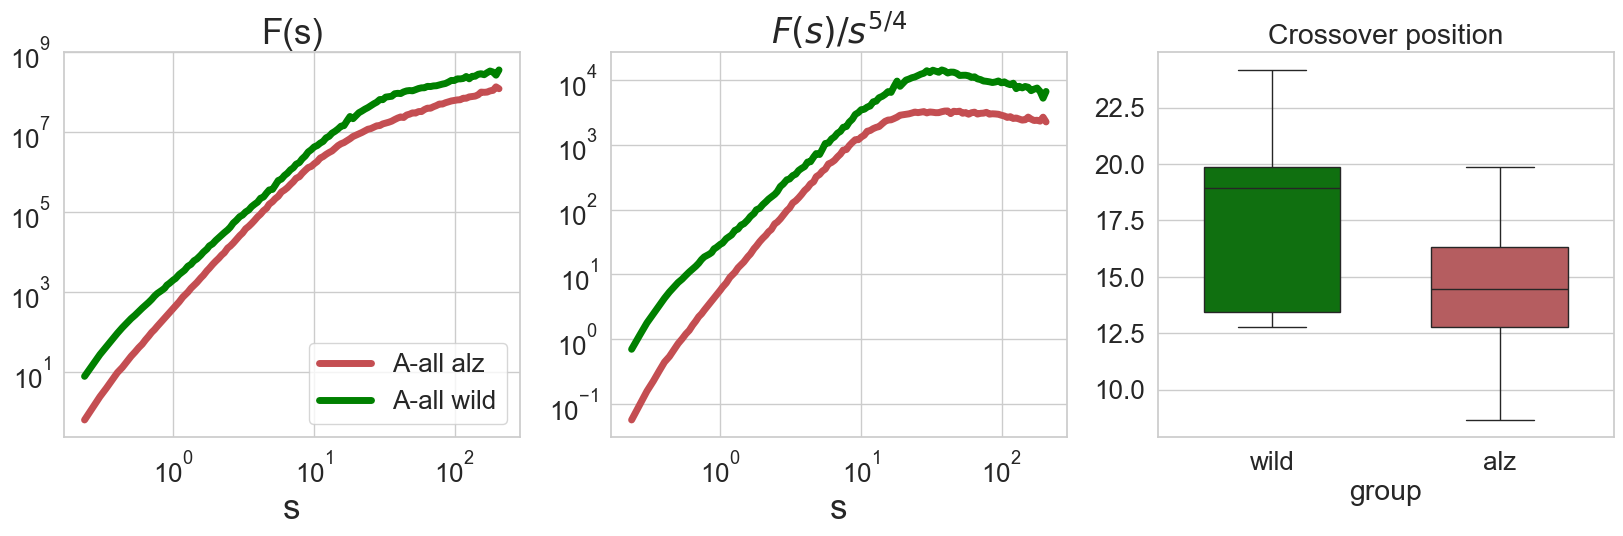

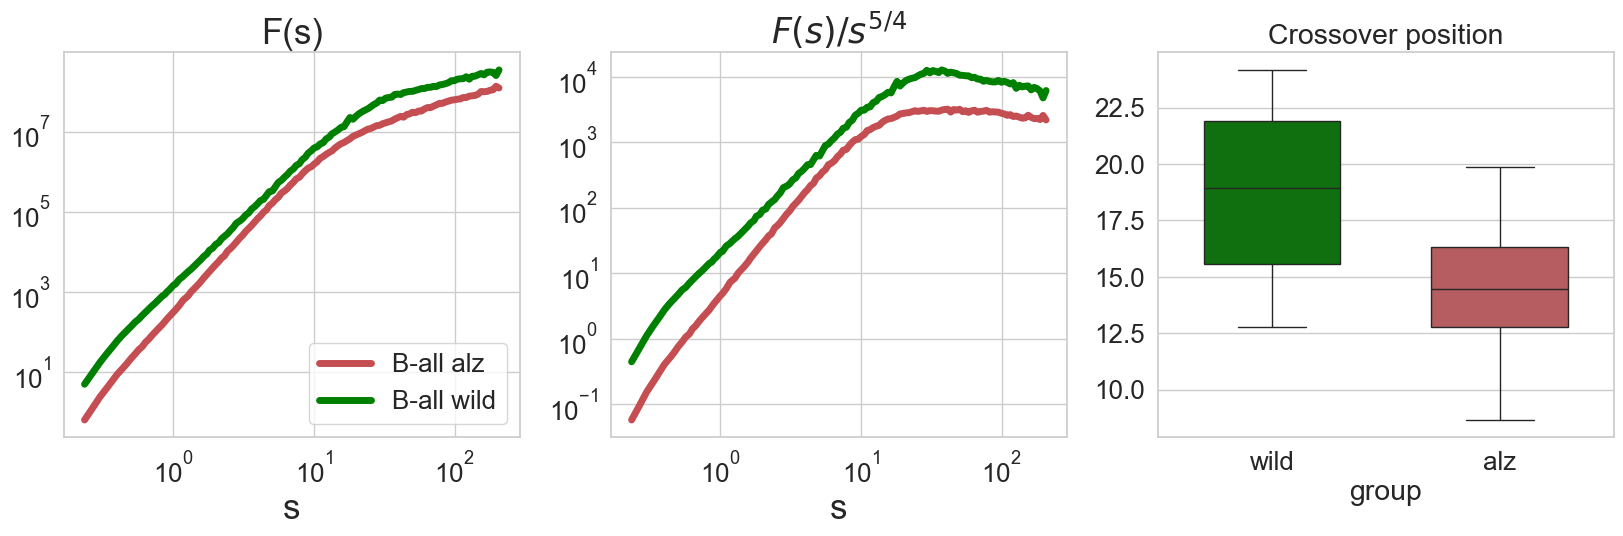

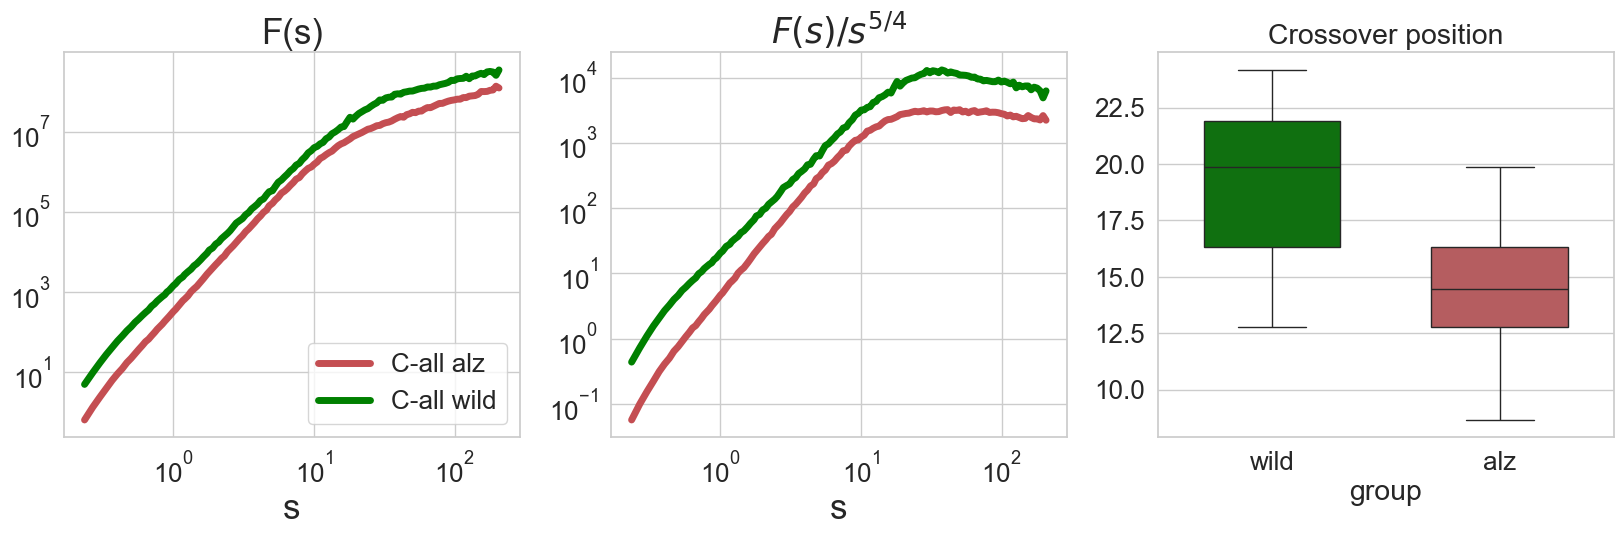

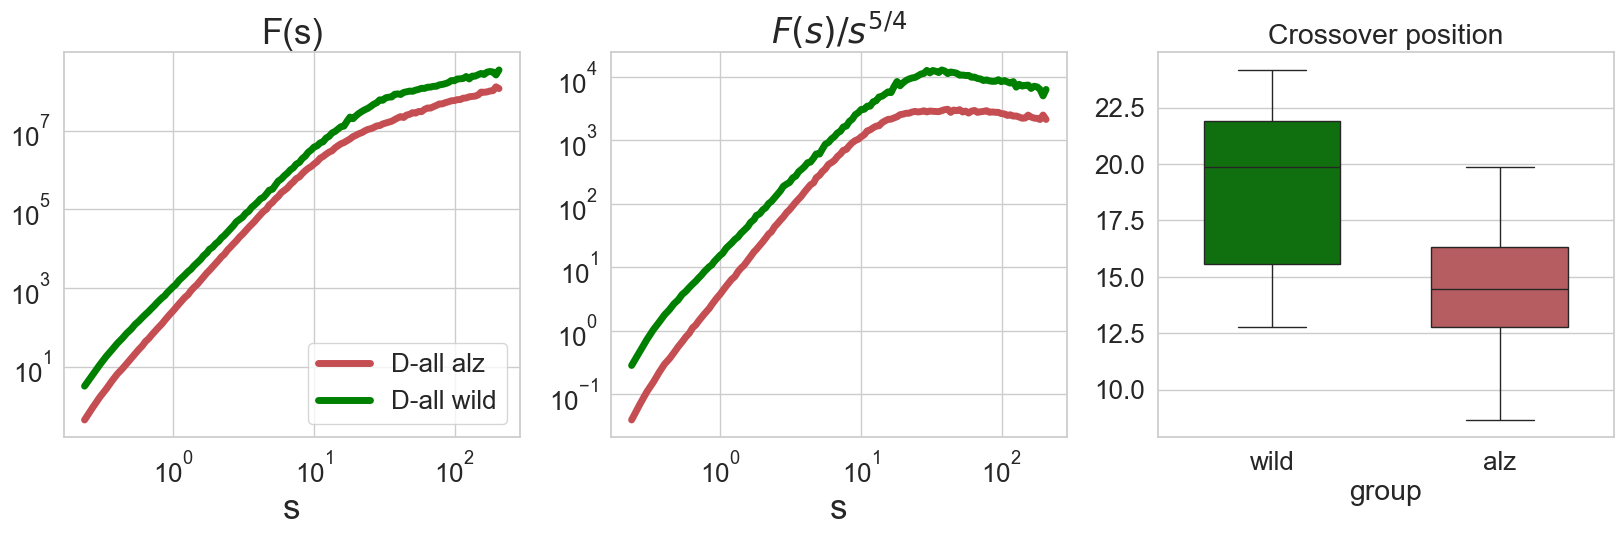

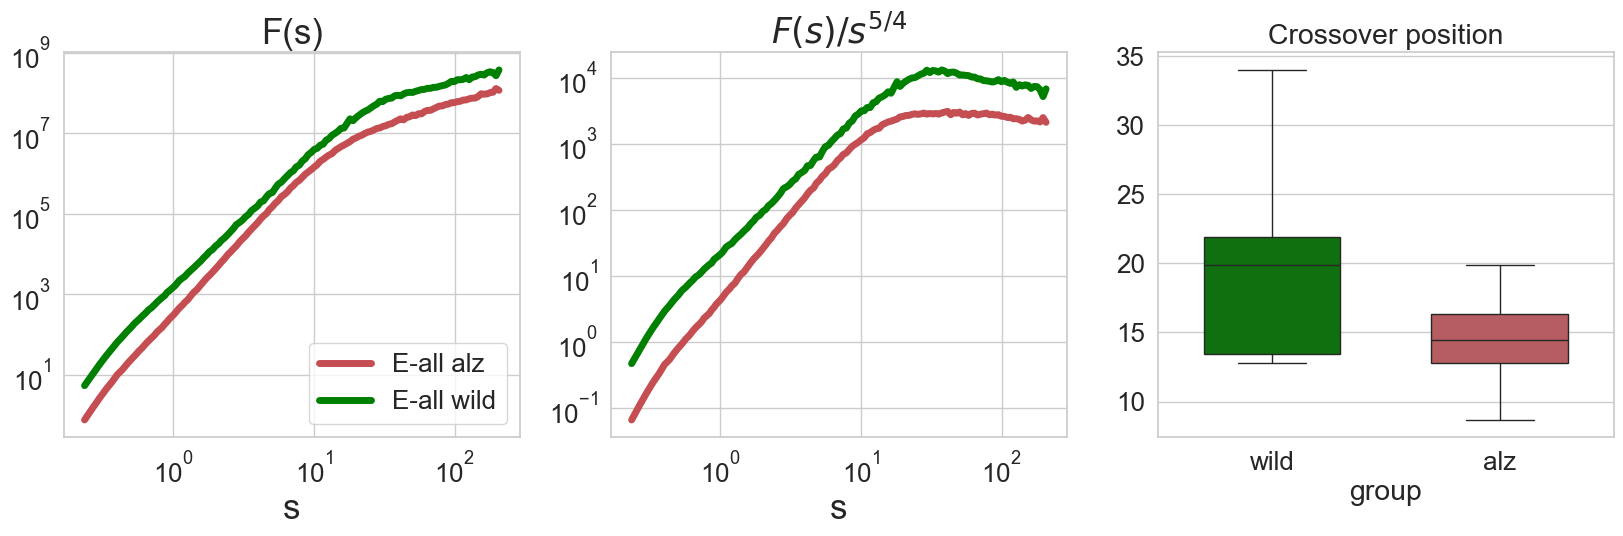

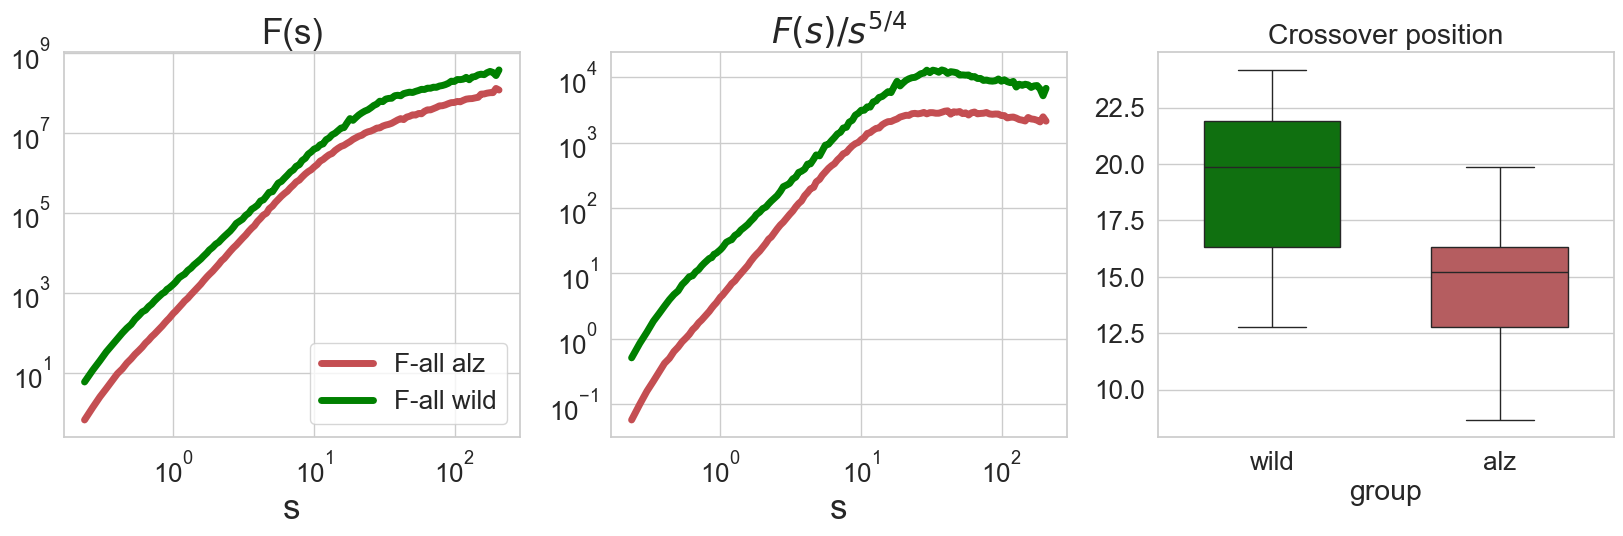

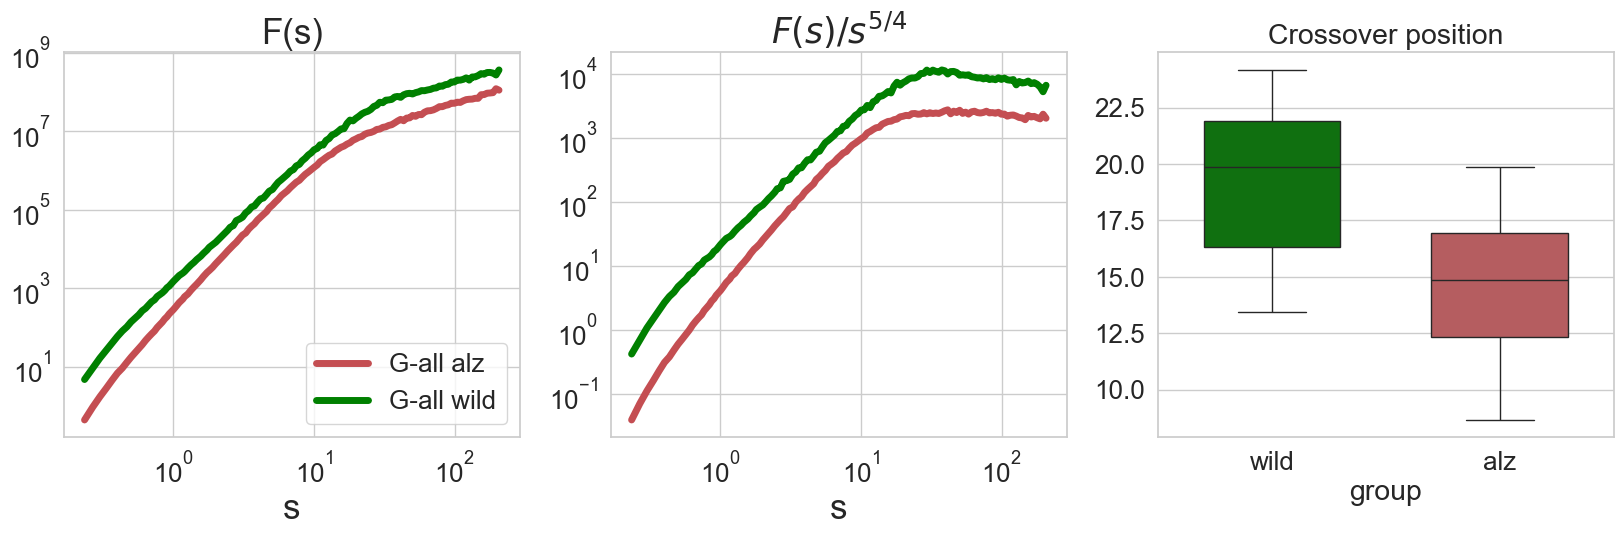

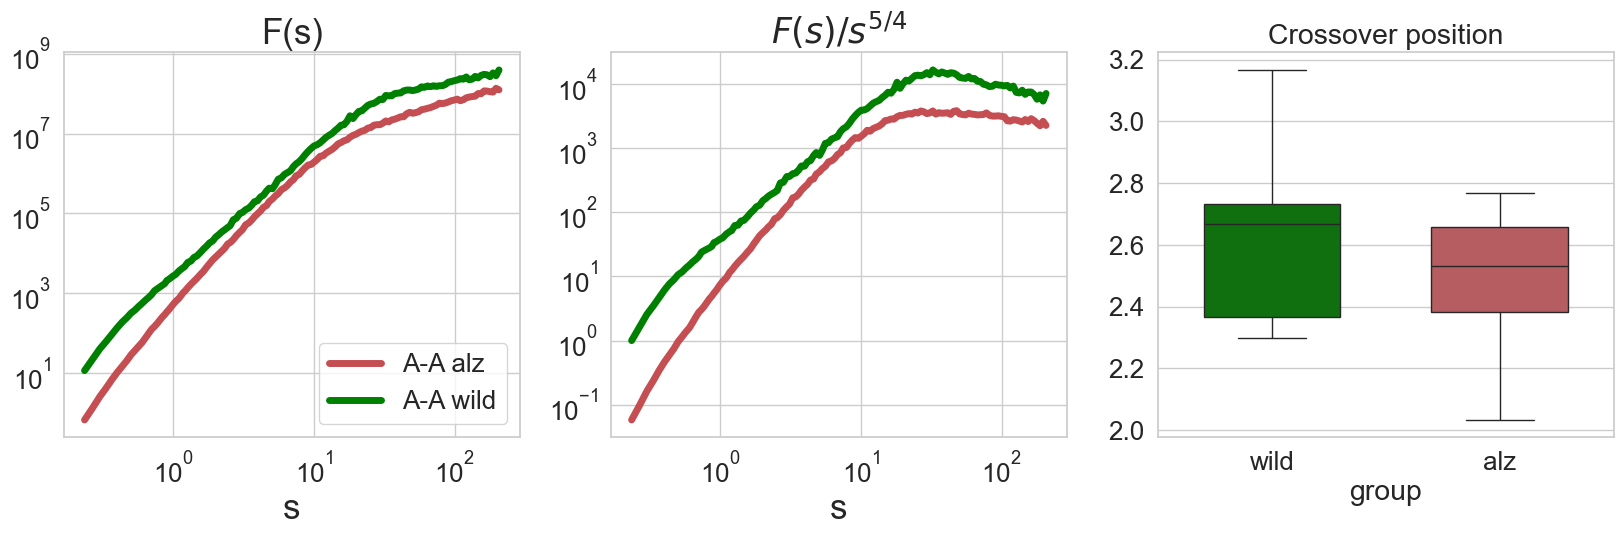

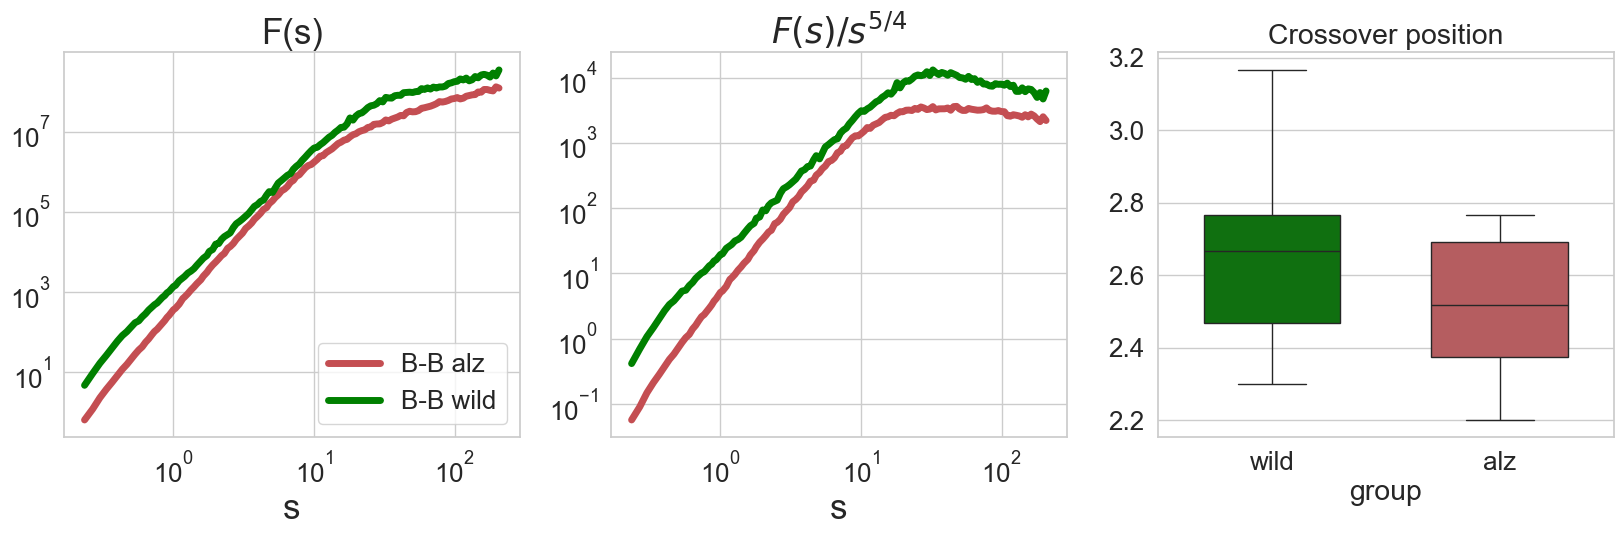

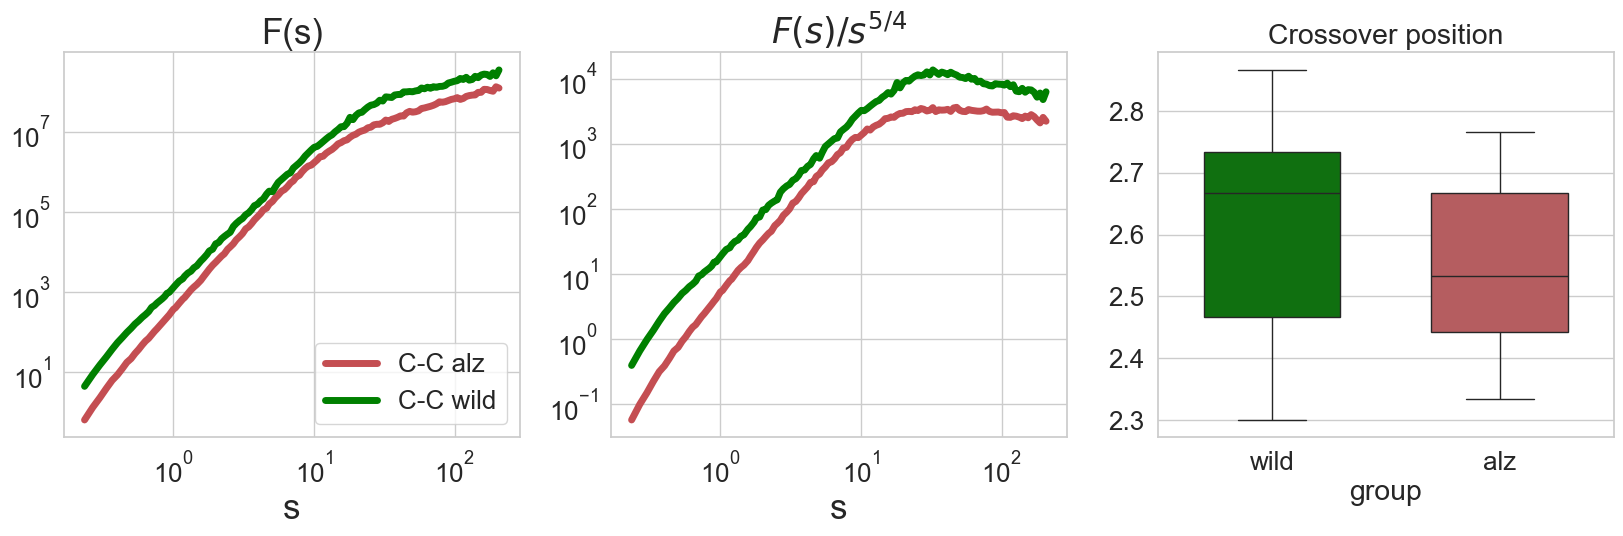

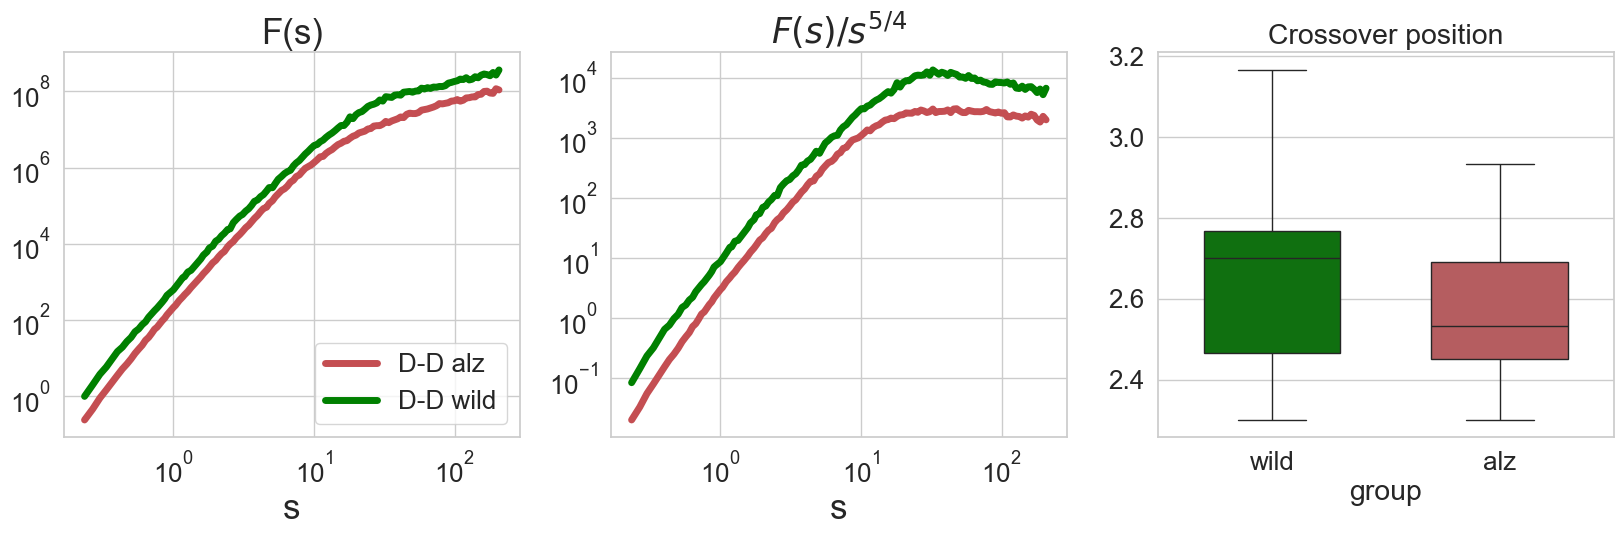

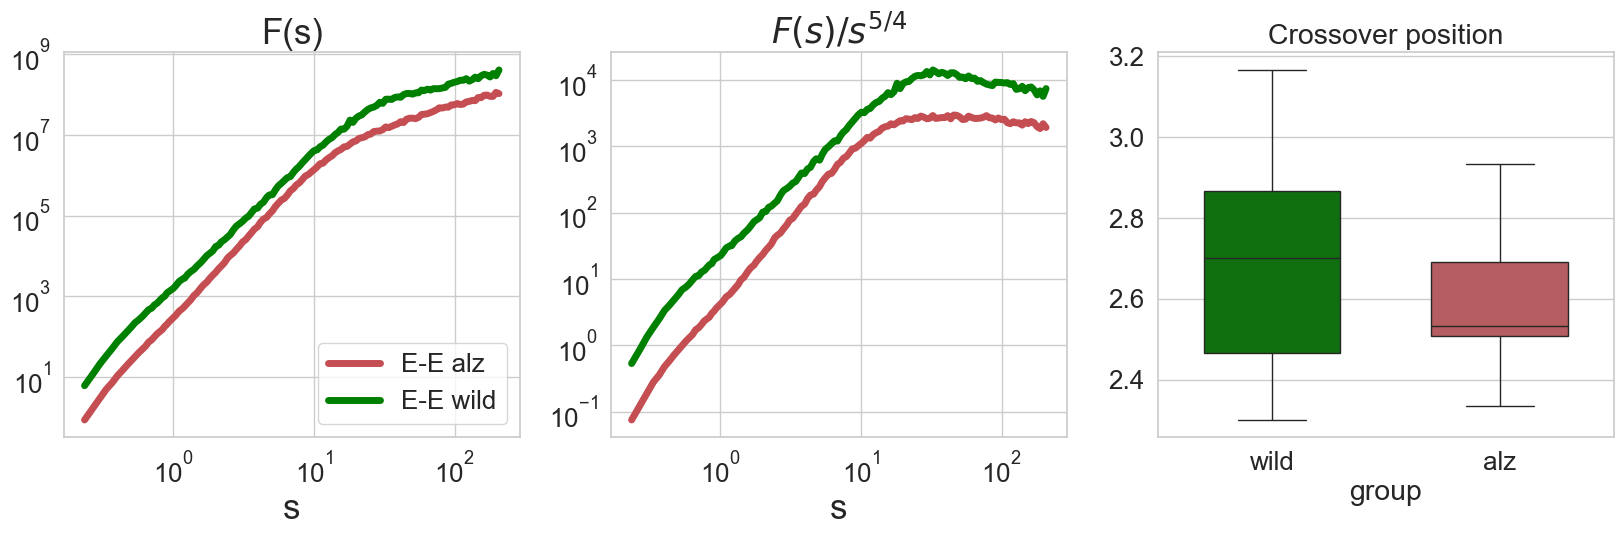

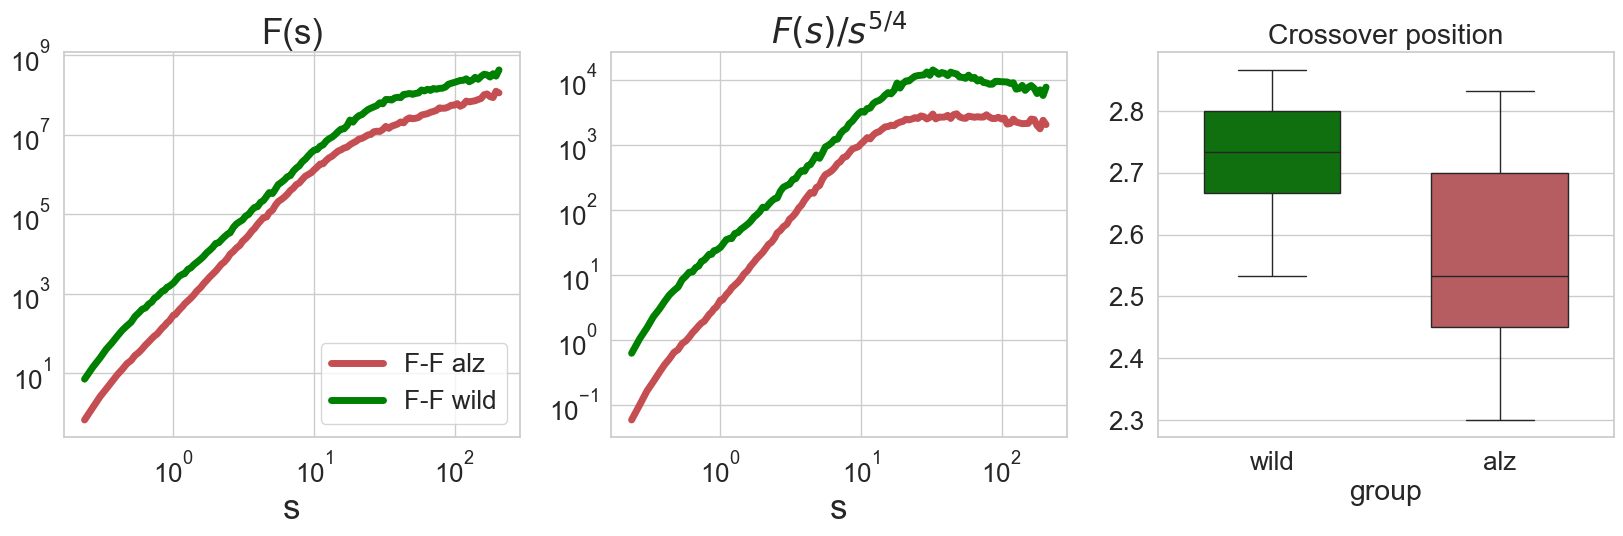

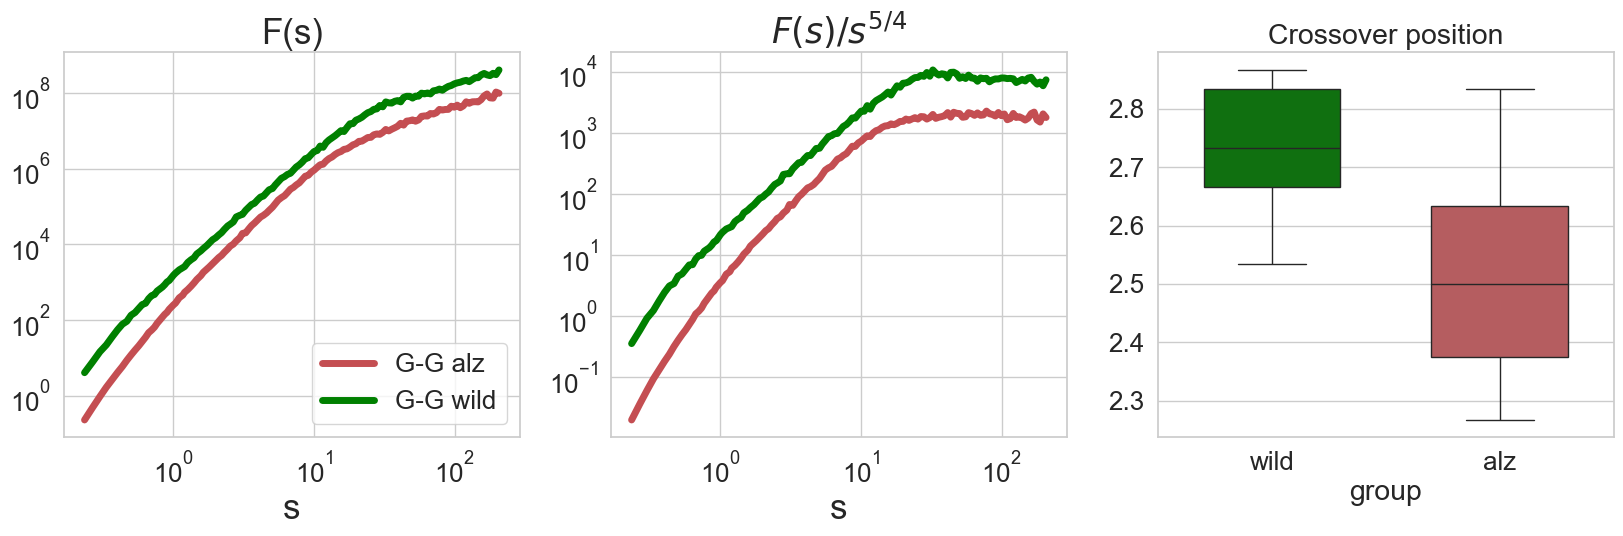

In [12]:
for body_part in body_parts:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
    flag_group = True
    body_part_df = data[data.name == body_part].reset_index(drop=True)
    body_part_df[body_part_df.columns[-1]] = body_part_df[body_part_df.columns[-1]] / 30
    sum_f = None
    for n, row_n in enumerate(range(body_part_df.shape[0])):
        if body_part_df.loc[row_n]["group"] == "alz":
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]["s"][1:-1].split(","):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]["f"][1:-1].replace("\n", "").split(" "):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f, f))
                f_alz = np.median(sum_f, axis=0)
            except Exception as e:
                sum_f = f
        else:
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]["s"][1:-1].split(","):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]["f"][1:-1].replace("\n", "").split(" "):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f, f))
                f_wild = np.median(sum_f, axis=0)
            except Exception as e:
                sum_f = f
                f_wild = sum_f
        # body_part_df.loc[row_n, "crossover_position"] = np.argmax(
        #     np.sqrt(f) * np.power(s, ROT_DEGREE)
        # )

    axs[0].loglog(
        s / 30, f_alz, linewidth=5, label=body_parts_dict[body_part] + " alz", color="r"
    )
    axs[0].loglog(
        s / 30,
        f_wild,
        linewidth=5,
        label=body_parts_dict[body_part] + " wild",
        color="green",
    )

    f_alz = f_alz * np.power(s, ROT_DEGREE)
    f_wild = f_wild * np.power(s, ROT_DEGREE)

    axs[1].loglog(s / 30, f_alz, linewidth=5, color="r")
    axs[1].loglog(s / 30, f_wild, linewidth=5, color="green")

    axs[0].grid(True)
    axs[0].set_title("F(s)", fontsize=25)
    axs[0].set_xlabel("s", fontsize=25)
    axs[0].legend(loc="lower right")

    axs[1].grid(True)
    axs[1].set_xlabel("s", fontsize=25)
    axs[1].set_title(ROT_DEGREE_STR, fontsize=25)

    axs[2].set_title("Crossover position")
    sns.boxplot(
        x="group",
        y="crossover_position",
        data=body_part_df,
        order=["wild", "alz"],
        width=0.6,
        showfliers=False,
        hue="group",
        palette=["green", "r"],
        legend=False,
        dodge=False,
        ax=axs[2],
    ).set(ylabel=" ")

    # plt.savefig(os.path.join(target_path, f'{body_parts_dict[body_part]}_y.eps'), format = "eps", bbox_inches='tight')
    plt.show()

Integral graphs

In [13]:
body_parts_dict_dfa = {
            'snout_x_snout_x':'A-A', 'leftforword_x_leftforword_x': 'B-B', 'rightforword_x_rightforword_x':'C-C', 'midbody_x_midbody_x':'D-D', 
            'leftback_x_leftback_x':'E-E', 'rightback_x_rightback_x':'F-F', 'tail_x_tail_x':'G-G',
            'snout_y_snout_y':'A-A', 'leftforword_y_leftforword_y': 'B-B', 'rightforword_y_rightforword_y':'C-C', 'midbody_y_midbody_y':'D-D', 
            'leftback_y_leftback_y':'E-E', 'rightback_y_rightback_y':'F-F', 'tail_y_tail_y':'G-G',
            }
body_parts_dict_dcca = {
            'snout_x_all':'A-all', 'leftforword_x_all': 'B-all', 'rightforword_x_all':'C-all', 'midbody_x_all':'D-all', 
            'leftback_x_all':'E-all', 'rightback_x_all':'F-all', 'tail_x_all':'G-all',
            'snout_y_all':'A-all', 'leftforword_y_all': 'B-all', 'rightforword_y_all':'C-all', 'midbody_y_all':'D-all', 
            'leftback_y_all':'E-all', 'rightback_y_all':'F-all', 'tail_y_all':'G-all',
            }

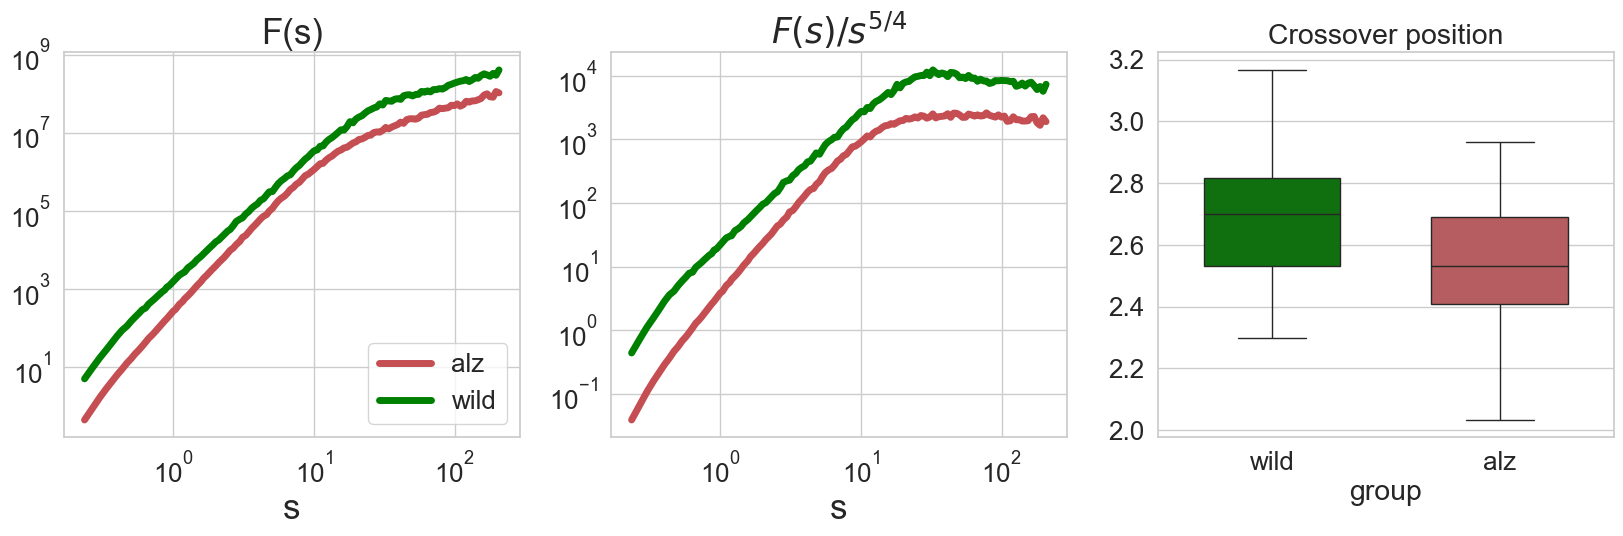

In [14]:
# graph body_parts dfa
all_body_parts_f_alz = None
all_body_parts_f_wild = None
all_body_part_df = pd.DataFrame([], columns=[])
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

for body_part in body_parts:
    if not body_part in body_parts_dict_dfa:
        continue
    flag_group = True
    body_part_df = data[data.name == body_part].reset_index(drop=True)
    body_part_df[body_part_df.columns[-1]] = body_part_df[body_part_df.columns[-1]] / 30
    for n, row_n in enumerate(range(body_part_df.shape[0])):
        if body_part_df.loc[row_n]["group"] == "alz":
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]["s"][1:-1].split(","):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]["f"][1:-1].replace("\n", "").split(" "):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f, f))
                f_alz = np.median(sum_f, axis=0)
            except:
                sum_f = f
        else:
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]["s"][1:-1].split(","):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]["f"][1:-1].replace("\n", "").split(" "):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f, f))
                f_wild = np.median(sum_f, axis=0)
            except:
                sum_f = f
                f_wild = sum_f
        # body_part_df.loc[row_n, "crossover_position"] = np.argmax(
        #     np.sqrt(f) * np.power(s, ROT_DEGREE)
        # )
    all_body_part_df = pd.concat(
        [all_body_part_df, body_part_df], axis=0, ignore_index=True
    )
    try:
        all_body_parts_f_alz = np.row_stack((all_body_parts_f_alz, f_alz))
        all_body_parts_f_alz = np.median(all_body_parts_f_alz, axis=0)
        all_body_parts_f_wild = np.row_stack((all_body_parts_f_wild, f_wild))
        all_body_parts_f_wild = np.median(all_body_parts_f_wild, axis=0)
    except:
        all_body_parts_f_alz = f_alz
        all_body_parts_f_wild = f_wild

axs[0].loglog(s / 30, all_body_parts_f_alz, linewidth=5, label="alz", color="r")
axs[0].loglog(s / 30, all_body_parts_f_wild, linewidth=5, label="wild", color="green")

all_body_parts_f_alz = all_body_parts_f_alz * np.power(s, ROT_DEGREE)
all_body_parts_f_wild = all_body_parts_f_wild * np.power(s, ROT_DEGREE)

axs[1].loglog(s / 30, all_body_parts_f_alz, linewidth=5, color="r")
axs[1].loglog(s / 30, all_body_parts_f_wild, linewidth=5, color="green")

axs[0].grid(True)
axs[0].set_title("F(s)", fontsize=25)
axs[0].set_xlabel("s", fontsize=25)
axs[0].legend(loc="lower right")

axs[1].grid(True)
axs[1].set_xlabel("s", fontsize=25)
axs[1].set_title(ROT_DEGREE_STR, fontsize=25)

axs[2].set_title("Crossover position")
sns.boxplot(
    x="group",
    y="crossover_position",
    data=all_body_part_df,
    order=["wild", "alz"],
    width=0.6,
    showfliers=False,
    hue="group",
    palette=["green", "r"],
    legend=False,
    dodge=False,
    ax=axs[2],
).set(ylabel=" ")

# plt.savefig(os.path.join(target_path, f'dfa_x.eps'), format = "eps", bbox_inches='tight')
plt.show()

In [15]:
# the Mann-Whitney U-test
x = all_body_part_df[all_body_part_df["group"] == "alz"]["crossover_position"]
y = all_body_part_df[all_body_part_df["group"] == "wild"]["crossover_position"]
U1, p = mannwhitneyu(
    np.array(x).astype(float), np.array(y).astype(float), alternative="two-sided"
)
print(f"p-value dfa X: {p:.10f}")

p-value dfa X: 0.0000393203


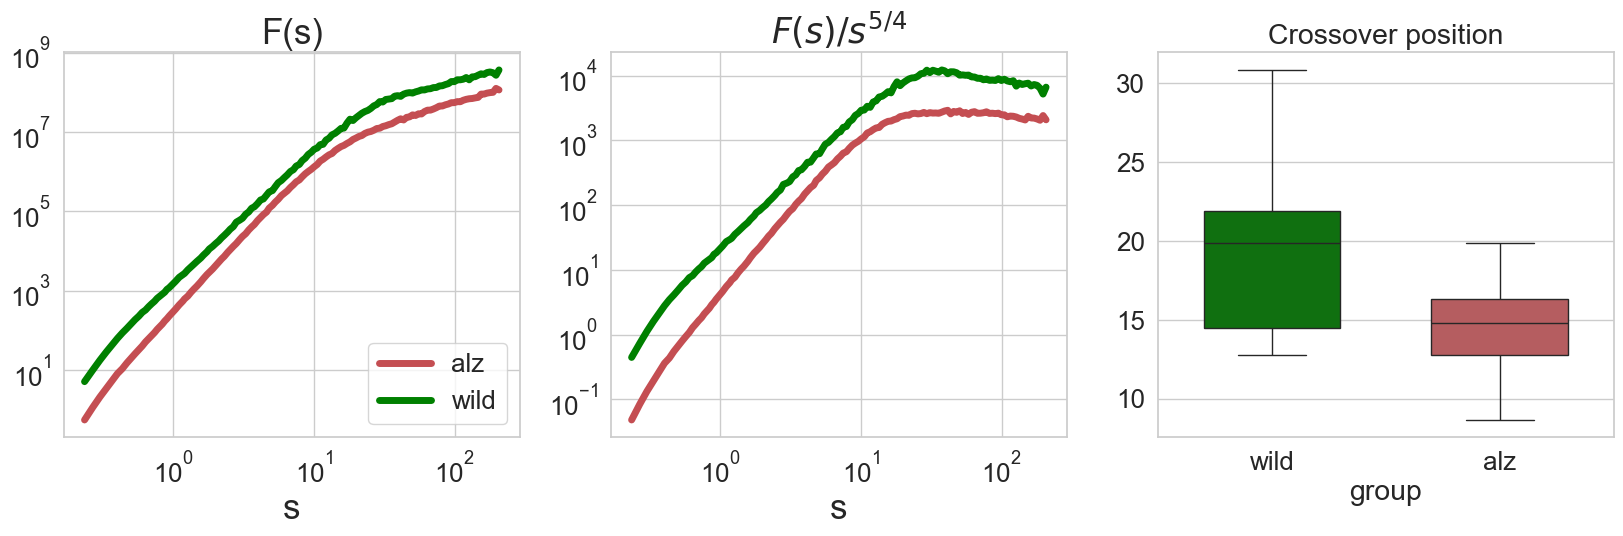

In [16]:
# graph body_parts dcca
all_body_parts_f_alz = None
all_body_parts_f_wild = None
all_body_part_df = pd.DataFrame([], columns=[])
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

for body_part in body_parts:
    if not body_part in body_parts_dict_dcca:
        continue
    flag_group = True
    body_part_df = data[data.name == body_part].reset_index(drop=True)
    body_part_df[body_part_df.columns[-1]] = body_part_df[body_part_df.columns[-1]] / 30
    for n, row_n in enumerate(range(body_part_df.shape[0])):
        if body_part_df.loc[row_n]["group"] == "alz":
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]["s"][1:-1].split(","):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]["f"][1:-1].replace("\n", "").split(" "):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f, f))
                f_alz = np.median(sum_f, axis=0)
            except:
                sum_f = f
        else:
            if flag_group:
                sum_f = None
                flag_group = False
            s = []
            for i in body_part_df.loc[row_n]["s"][1:-1].split(","):
                s.append(float(i))
            s = np.array(s)
            f = []
            for i in body_part_df.loc[row_n]["f"][1:-1].replace("\n", "").split(" "):
                f.append(float(i))
            try:
                sum_f = np.row_stack((sum_f, f))
                f_wild = np.median(sum_f, axis=0)
            except:
                sum_f = f
                f_wild = sum_f
        # body_part_df.loc[row_n, "crossover_position"] = np.argmax(
        #     np.sqrt(f) * np.power(s, ROT_DEGREE)
        # )
    all_body_part_df = pd.concat(
        [all_body_part_df, body_part_df], axis=0, ignore_index=True
    )
    try:
        all_body_parts_f_alz = np.row_stack((all_body_parts_f_alz, f_alz))
        all_body_parts_f_alz = np.median(all_body_parts_f_alz, axis=0)
        all_body_parts_f_wild = np.row_stack((all_body_parts_f_wild, f_wild))
        all_body_parts_f_wild = np.median(all_body_parts_f_wild, axis=0)
    except:
        all_body_parts_f_alz = f_alz
        all_body_parts_f_wild = f_wild

axs[0].loglog(s / 30, all_body_parts_f_alz, linewidth=5, label="alz", color="r")
axs[0].loglog(s / 30, all_body_parts_f_wild, linewidth=5, label="wild", color="green")


all_body_parts_f_alz = all_body_parts_f_alz * np.power(s, ROT_DEGREE)
all_body_parts_f_wild = all_body_parts_f_wild * np.power(s, ROT_DEGREE)

axs[1].loglog(s / 30, all_body_parts_f_alz, linewidth=5, color="r")
axs[1].loglog(s / 30, all_body_parts_f_wild, linewidth=5, color="green")

axs[0].grid(True)
axs[0].set_title("F(s)", fontsize=25)
axs[0].set_xlabel("s", fontsize=25)
axs[0].legend(loc="lower right")

axs[1].grid(True)
axs[1].set_xlabel("s", fontsize=25)
axs[1].set_title(ROT_DEGREE_STR, fontsize=25)

axs[2].set_title("Crossover position")
sns.boxplot(
    x="group",
    y="crossover_position",
    data=all_body_part_df,
    order=["wild", "alz"],
    width=0.6,
    showfliers=False,
    hue="group",
    palette=["green", "r"],
    legend=False,
    dodge=False,
    ax=axs[2],
).set(ylabel=" ")

# plt.savefig(os.path.join(target_path, f'dcca_x.eps'), format = "eps", bbox_inches='tight')
plt.show()

In [17]:
# the Mann-Whitney U-test
x = all_body_part_df[all_body_part_df["group"] == "alz"]["crossover_position"]
y = all_body_part_df[all_body_part_df["group"] == "wild"]["crossover_position"]
U1, p = mannwhitneyu(
    np.array(x).astype(float), np.array(y).astype(float), alternative="two-sided"
)

print(f"p-value dfa X: {p:.10f}")

p-value dfa X: 0.0000000005
